In [103]:
import re
import time
from datetime import datetime, timedelta
from google.colab import userdata

# Third-party libraries for web scraping
import requests
from bs4 import BeautifulSoup

# PySpark imports
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import (
    lit, col, expr, lag, ceil, from_unixtime, to_date, avg, window
)
from pyspark.sql.window import Window

# Data analysis and visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

API_KEY = userdata.get('STEAM_API_KEY')
spark = SparkSession.builder.appName("SteamCorrelation").getOrCreate()

# Fetch top-50 games
r = requests.get(f"https://api.steampowered.com/ISteamChartsService/GetGamesByConcurrentPlayers/v1/?key={API_KEY}")
top50 = r.json()["response"]["ranks"][:50]

def get_game_name(appid):
    r = requests.get(f"https://store.steampowered.com/api/appdetails?appids={appid}")
    return r.json().get(str(appid), {}).get("data", {}).get("name", "Unknown")

def get_last_update_from_news(appid):
    try:
        url = f"https://api.steampowered.com/ISteamNews/GetNewsForApp/v2/?appid={appid}&count=5&maxlength=0&format=json"
        r = requests.get(url)
        newsitems = r.json().get("appnews", {}).get("newsitems", [])
        for item in newsitems:
            title = item.get("title", "").lower()
            if "update" in title or "patch" in title or "release" in title:
                return datetime.utcfromtimestamp(item["date"]).date()
        return None
    except:
        return None


rows=[]
for g in top50:
    appid=g["appid"]
    name=get_game_name(appid); time.sleep(0.5)
    lastupd = get_last_update_from_news(appid)
    rows.append((appid, g["rank"], name, datetime.today().date(), lastupd))

schema = StructType([
    StructField("AppID", IntegerType()),
    StructField("Rank", IntegerType()),
    StructField("Name", StringType()),
    StructField("SnapshotDate", DateType()),
    StructField("LastUpdated", DateType())
])
df_top = spark.createDataFrame(rows, schema)
df_top.filter(col("LastUpdated").isNotNull()).show(10, truncate=False)

+-------+----+---------------------------------+------------+-----------+
|AppID  |Rank|Name                             |SnapshotDate|LastUpdated|
+-------+----+---------------------------------+------------+-----------+
|730    |1   |Counter-Strike 2                 |2025-07-16  |2025-07-16 |
|570    |2   |Dota 2                           |2025-07-16  |2025-06-24 |
|252490 |5   |Rust                             |2025-07-16  |2025-07-04 |
|2767030|6   |Marvel Rivals                    |2025-07-16  |2025-07-15 |
|359550 |7   |Tom Clancy's Rainbow Six® Siege X|2025-07-16  |2025-07-15 |
|2923300|9   |Banana                           |2025-07-16  |2025-07-15 |
|381210 |11  |Dead by Daylight                 |2025-07-16  |2025-07-14 |
|294100 |12  |RimWorld                         |2025-07-16  |2025-07-15 |
|2669320|13  |EA SPORTS FC™ 25                 |2025-07-16  |2025-07-02 |
|1172470|14  |Apex Legends™                    |2025-07-16  |2025-07-07 |
+-------+----+------------------------

In [56]:
def get_monthly_review_rollups(appid):
    try:
        url = f"https://store.steampowered.com/appreviewhistogram/{appid}"
        r = requests.get(url)
        data = r.json()
        rollups = data.get("results", {}).get("rollups", [])
        return [(appid, r["date"], r["recommendations_up"], r["recommendations_down"]) for r in rollups]
    except Exception as e:
        print(f"Failed to fetch for AppID {appid}: {e}")
        return []

rollup_data = []
for row in df_top_games_by_players.collect():
    appid = row["AppID"]
    rollup_data.extend(get_monthly_review_rollups(appid))
    time.sleep(1)

if rollup_data:
    df_reviews_split = spark.createDataFrame(
        rollup_data, ["AppID", "Timestamp", "ThumbsUp", "ThumbsDown"]
    ).withColumn("Date", to_date(from_unixtime(col("Timestamp")))).drop("Timestamp")

    df_reviews_split.show(10, truncate=False)
else:
    print("⚠️ No review rollup data found.")


+-----+--------+----------+----------+
|AppID|ThumbsUp|ThumbsDown|Date      |
+-----+--------+----------+----------+
|730  |1       |0         |2012-05-01|
|730  |1630    |208       |2012-08-01|
|730  |1003    |88        |2012-09-01|
|730  |511     |59        |2012-10-01|
|730  |591     |62        |2012-11-01|
|730  |867     |93        |2012-12-01|
|730  |690     |78        |2013-01-01|
|730  |598     |68        |2013-02-01|
|730  |529     |55        |2013-03-01|
|730  |495     |53        |2013-04-01|
+-----+--------+----------+----------+
only showing top 10 rows



In [55]:
def get_price_data(appid, name):
    params={"term":name,"cc":"US","l":"english"}
    j = requests.get("https://store.steampowered.com/api/storesearch/", params=params).json()
    for itm in j.get("items", []):
        if itm.get("id")==appid:
            p=itm.get("price",{})
            pi=p.get("initial",0)/100
            pf=p.get("final",0)/100
            cur=p.get("currency") or "N/A"
            return (appid, pf, cur)
    return (appid, 0.0, "N/A")

pr=[]
for row in df_top.collect():
    pr.append(get_price_data(row.AppID, row.Name))
    time.sleep(1)

price_schema = ["AppID","PriceFinal","Currency"]
df_price = spark.createDataFrame(pr, price_schema).withColumn(
    "IsFree", (col("PriceFinal")==0.0)
)
df_price.show(5)


+-------+----------+--------+------+
|  AppID|PriceFinal|Currency|IsFree|
+-------+----------+--------+------+
|    730|       0.0|     N/A|  true|
|    570|       0.0|     N/A|  true|
| 578080|       0.0|     N/A|  true|
|3419430|       0.0|     N/A|  true|
| 252490|     39.99|     USD| false|
+-------+----------+--------+------+
only showing top 5 rows



In [59]:
six_months = datetime.today() - timedelta(days=180)

df_combined = df_reviews_split.join(df_price, "AppID", "inner") \
    .join(df_top.select("AppID", "Rank", "LastUpdated", "SnapshotDate"), "AppID", "inner")

df_recent = df_combined.filter(col("Date") >= lit(six_months.date()))

df_paid = df_recent.filter(~col("IsFree"))
df_free = df_recent.filter(col("IsFree"))

print("📦 Paid Games (last 6 months):")
df_paid.select("AppID", "Date", "ThumbsUp", "ThumbsDown", "PriceFinal", "Currency", "Rank", "LastUpdated").show(50)

print("🎮 Free Games (last 6 months):")
df_free.select("AppID", "Date", "ThumbsUp", "ThumbsDown", "PriceFinal", "Currency", "Rank", "LastUpdated").show(50)


📦 Paid Games (last 6 months):
+-------+----------+--------+----------+----------+--------+----+-----------+
|  AppID|      Date|ThumbsUp|ThumbsDown|PriceFinal|Currency|Rank|LastUpdated|
+-------+----------+--------+----------+----------+--------+----+-----------+
|2669320|2025-07-11|     961|       642|     69.99|     USD|  14| 2025-07-02|
|2669320|2025-07-04|    1335|      1044|     69.99|     USD|  14| 2025-07-02|
|2669320|2025-06-27|    1602|      1076|     69.99|     USD|  14| 2025-07-02|
|2669320|2025-06-20|    1449|      1152|     69.99|     USD|  14| 2025-07-02|
|2669320|2025-06-13|     464|       460|     69.99|     USD|  14| 2025-07-02|
|2669320|2025-06-06|     448|       463|     69.99|     USD|  14| 2025-07-02|
|2669320|2025-05-30|     608|       538|     69.99|     USD|  14| 2025-07-02|
|2669320|2025-05-23|     636|       554|     69.99|     USD|  14| 2025-07-02|
|2669320|2025-05-16|     732|       581|     69.99|     USD|  14| 2025-07-02|
|2669320|2025-05-09|     902|     

In [65]:
df_sentiment = df_recent.withColumn("TotalReviews", col("ThumbsUp") + col("ThumbsDown")) \
    .withColumn("PositivityRatio", expr("ThumbsUp / TotalReviews"))

w = Window.partitionBy("AppID").orderBy("Date")

df_sentiment = df_sentiment.withColumn("ReviewDelta", col("TotalReviews") - lag("TotalReviews").over(w)) \
    .withColumn("SentimentDelta", col("PositivityRatio") - lag("PositivityRatio").over(w))

def round_up_2dec(col_name):
    return (ceil(col(col_name) * 100) / 100)

df_sentiment = df_sentiment.withColumn("PositivityRatio", round_up_2dec("PositivityRatio")) \
    .withColumn("ReviewDelta", round_up_2dec("ReviewDelta")) \
    .withColumn("SentimentDelta", round_up_2dec("SentimentDelta"))

df_sentiment = df_sentiment.withColumn("IsPostUpdate", expr("Date >= LastUpdated"))

df_paid_sentiment = df_sentiment.filter(~col("IsFree"))
df_free_sentiment = df_sentiment.filter(col("IsFree"))

print("📦 Paid Games Sentiment Insights:")
df_paid_sentiment.select("AppID", "Date", "ThumbsUp", "ThumbsDown", "TotalReviews", "PositivityRatio", "ReviewDelta", "SentimentDelta", "PriceFinal", "Currency", "Rank", "LastUpdated", "IsPostUpdate").show(50, truncate=False)

print("🎮 Free Games Sentiment Insights:")
df_free_sentiment.select("AppID", "Date", "ThumbsUp", "ThumbsDown", "TotalReviews", "PositivityRatio", "ReviewDelta", "SentimentDelta", "PriceFinal", "Currency", "Rank", "LastUpdated", "IsPostUpdate").show(50, truncate=False)


📦 Paid Games Sentiment Insights:
+------+----------+--------+----------+------------+---------------+-----------+--------------+----------+--------+----+-----------+------------+
|AppID |Date      |ThumbsUp|ThumbsDown|TotalReviews|PositivityRatio|ReviewDelta|SentimentDelta|PriceFinal|Currency|Rank|LastUpdated|IsPostUpdate|
+------+----------+--------+----------+------------+---------------+-----------+--------------+----------+--------+----+-----------+------------+
|4000  |2025-02-01|7306    |271       |7577        |0.97           |NULL       |NULL          |5.99      |USD     |49  |2025-07-15 |false       |
|4000  |2025-03-01|8099    |281       |8380        |0.97           |803.0      |0.01          |5.99      |USD     |49  |2025-07-15 |false       |
|4000  |2025-04-01|5970    |222       |6192        |0.97           |-2188.0    |0.0           |5.99      |USD     |49  |2025-07-15 |false       |
|4000  |2025-05-01|5828    |213       |6041        |0.97           |-151.0     |0.01       

In [64]:
w_7d = Window.partitionBy("AppID").orderBy("Date").rowsBetween(-6, 0)   # last 7 days (including current)
w_30d = Window.partitionBy("AppID").orderBy("Date").rowsBetween(-29, 0) # last 30 days

df_trends = df_sentiment \
    .withColumn("PositivityRatio_7dAvg", avg("PositivityRatio").over(w_7d)) \
    .withColumn("TotalReviews_7dAvg", avg("TotalReviews").over(w_7d)) \
    .withColumn("PositivityRatio_30dAvg", avg("PositivityRatio").over(w_30d)) \
    .withColumn("TotalReviews_30dAvg", avg("TotalReviews").over(w_30d))

df_trends.select("AppID", "Date", "PositivityRatio", "PositivityRatio_7dAvg", "PositivityRatio_30dAvg",
                 "TotalReviews", "TotalReviews_7dAvg", "TotalReviews_30dAvg").show(50, truncate=False)


+------+----------+------------------+---------------------+----------------------+------------+------------------+-------------------+
|AppID |Date      |PositivityRatio   |PositivityRatio_7dAvg|PositivityRatio_30dAvg|TotalReviews|TotalReviews_7dAvg|TotalReviews_30dAvg|
+------+----------+------------------+---------------------+----------------------+------------+------------------+-------------------+
|440   |2025-02-01|0.9369310793237972|0.9369310793237972   |0.9369310793237972    |7690        |7690.0            |7690.0             |
|440   |2025-03-01|0.9445882962195753|0.9407596877716862   |0.9407596877716862    |7724        |7707.0            |7707.0             |
|440   |2025-04-01|0.9441868452687618|0.9419020736040448   |0.9419020736040448    |5823        |7079.0            |7079.0             |
|440   |2025-05-01|0.9608433734939759|0.9466373985765275   |0.9466373985765275    |8964        |7550.25           |7550.25            |
|440   |2025-06-01|0.9485771342985522|0.94702534

In [67]:
pandas_df = df_sentiment.toPandas()

numeric_df = pandas_df.select_dtypes(include=["number"])

print(numeric_df.corr())


                    AppID  ThumbsUp  ThumbsDown  PriceFinal      Rank  \
AppID            1.000000 -0.268968   -0.212825   -0.041343 -0.189514   
ThumbsUp        -0.268968  1.000000    0.842098   -0.171451 -0.087802   
ThumbsDown      -0.212825  0.842098    1.000000   -0.174231 -0.259957   
PriceFinal      -0.041343 -0.171451   -0.174231    1.000000  0.204316   
Rank            -0.189514 -0.087802   -0.259957    0.204316  1.000000   
TotalReviews    -0.264562  0.993962    0.896192   -0.176489 -0.125119   
PositivityRatio -0.168772  0.123011   -0.267639    0.016502  0.348638   
ReviewDelta      0.053695 -0.131908   -0.118632    0.036435  0.015608   
SentimentDelta   0.022976 -0.008276   -0.124568    0.017815  0.015426   

                 TotalReviews  PositivityRatio  ReviewDelta  SentimentDelta  
AppID               -0.264562        -0.168772     0.053695        0.022976  
ThumbsUp             0.993962         0.123011    -0.131908       -0.008276  
ThumbsDown           0.896192      

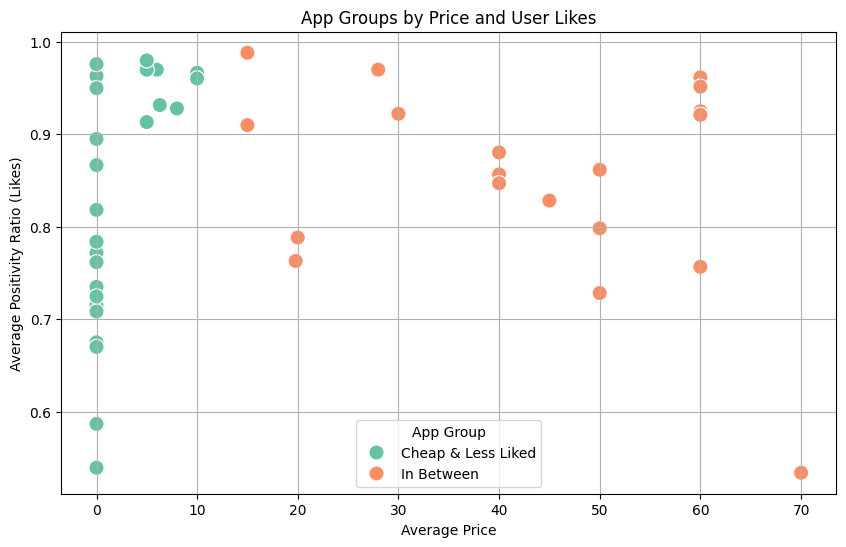

In [91]:
# Calculate percentiles for price and positivity centers
price_33 = np.percentile(centers_df["PriceFinal"], 33)
price_67 = np.percentile(centers_df["PriceFinal"], 67)
pos_33 = np.percentile(centers_df["PositivityRatio"], 33)
pos_67 = np.percentile(centers_df["PositivityRatio"], 67)

def label_cluster_flexible(row):
    price = row["PriceFinal"]
    pos = row["PositivityRatio"]

    high_price = price >= price_67
    low_price = price <= price_33
    high_pos = pos >= pos_67
    low_pos = pos <= pos_33

    if high_price and high_pos:
        return "Expensive & Well Liked"
    elif low_price and low_pos:
        return "Cheap & Less Liked"
    else:
        return "In Between"

centers_df["Label"] = centers_df.apply(label_cluster_flexible, axis=1)

cluster_labels = centers_df["Label"].to_dict()
agg_df["ClusterLabel"] = agg_df["Cluster"].map(cluster_labels)

plt.figure(figsize=(10,6))
sns.scatterplot(data=agg_df, x="PriceFinal", y="PositivityRatio", hue="ClusterLabel", palette="Set2", s=120)
plt.title("App Groups by Price and User Likes")
plt.xlabel("Average Price")
plt.ylabel("Average Positivity Ratio (Likes)")
plt.legend(title="App Group")
plt.grid(True)
plt.show()


Explanation:

This chart groups apps based on two things: their average price and how much users like them (called the “positivity ratio”). We divided the apps into three groups:

Expensive & Well Liked: These apps cost more and have lots of happy users.

Cheap & Less Liked: These apps are cheaper but don’t get as many positive reviews.

In Between: Apps that fall somewhere in the middle — either moderately priced or have an average level of user satisfaction.

By looking at the chart, you can quickly see how apps compare in terms of price and user happiness. This helps understand what kind of apps are popular and whether paying more usually means happier users or not.

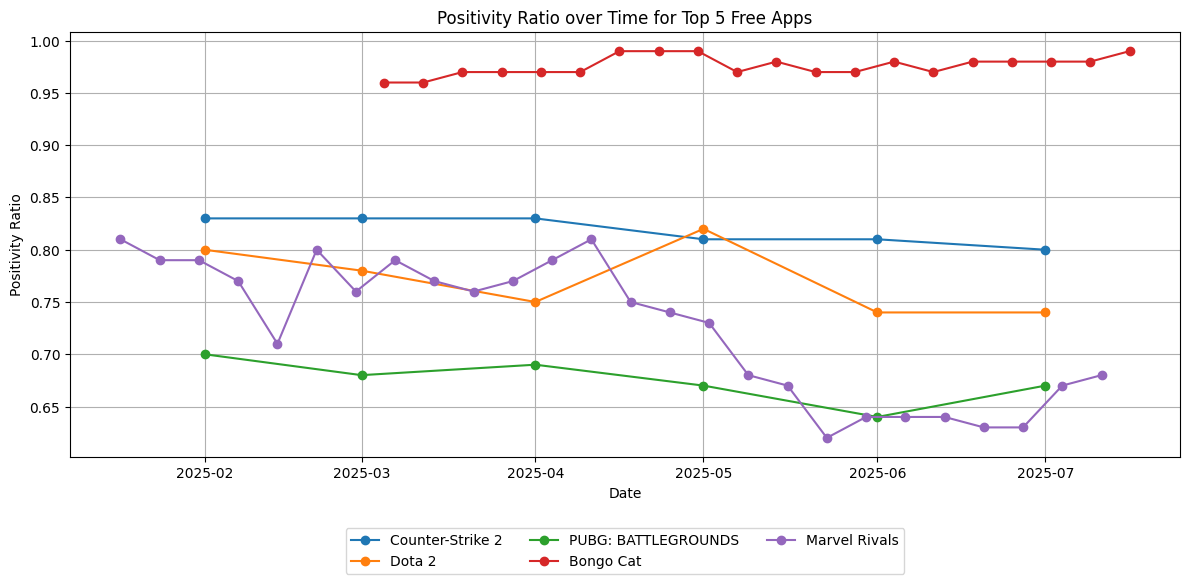

In [95]:
plt.figure(figsize=(12,6))

for app in top_apps:
    subset = df_free_pd[df_free_pd["AppID"] == app]
    if subset.empty:
        print(f"No data for AppID {app}")
        continue
    app_name = subset["Name"].iloc[0]
    plt.plot(subset["Date"], subset["PositivityRatio"], marker='o', label=app_name)

plt.title("Positivity Ratio over Time for Top 5 Free Apps")
plt.xlabel("Date")
plt.ylabel("Positivity Ratio")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.grid(True)
plt.tight_layout()
plt.show()


**What this chart shows:**

This chart tracks how much people liked the top 5 free games over time. The vertical axis (Positivity Ratio) tells us the share of positive reviews compared to all reviews on a given day — higher means more players gave thumbs up. The horizontal axis is the timeline, showing how this changed day by day.

**What to notice:**

Each line represents a different game, so you can compare how player satisfaction changes for each one.

If a line goes up, it means more players liked the game on those days. If it goes down, fewer players liked it.

The chart helps spot patterns like whether a game’s popularity is steady, improving, or dropping over time.

**In short:**

this helps us see which free games players are enjoying the most, and how that feeling changes as the game updates or new players join.


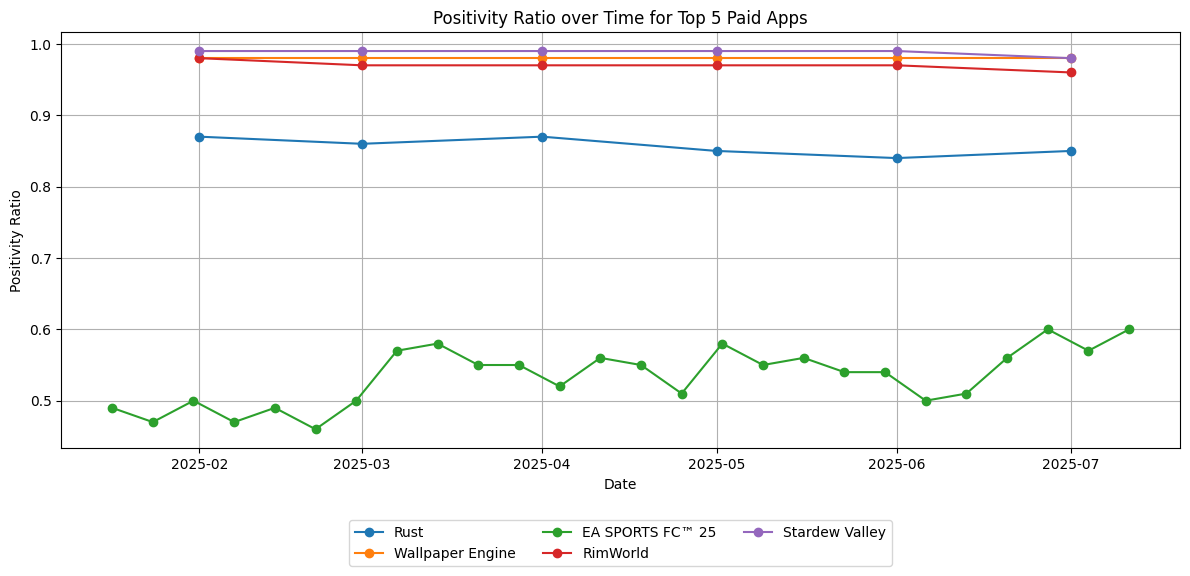

In [96]:
df_paid_named = df_paid_sentiment.join(df_top.select("AppID", "Name"), "AppID", "left")

df_paid_pd = df_paid_named.toPandas()

df_paid_pd['Date'] = pd.to_datetime(df_paid_pd['Date'])

top_apps = df_paid_pd.groupby("AppID")["Rank"].min().nsmallest(5).index.tolist()

plt.figure(figsize=(12,6))

for app in top_apps:
    subset = df_paid_pd[df_paid_pd["AppID"] == app]
    app_name = subset["Name"].iloc[0] if not subset.empty else str(app)
    plt.plot(subset["Date"], subset["PositivityRatio"], marker='o', label=app_name)

plt.title("Positivity Ratio over Time for Top 5 Paid Apps")
plt.xlabel("Date")
plt.ylabel("Positivity Ratio")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)
plt.grid(True)
plt.tight_layout()
plt.show()


**What this chart shows:**

This chart tracks how much players liked the top 5 paid games over time. The vertical axis shows the positivity ratio — basically, how many reviews were positive compared to the total reviews on each day. The horizontal axis shows the timeline.

**What to notice:**

Each line represents a different paid game, so you can see which ones players enjoyed more or less over time.

When a line goes up, it means more players gave positive feedback that day. When it goes down, fewer players liked the game.

This helps us understand if updates, new content, or changes made players happier or less happy.

**In short: **

this visualization helps spot trends in player satisfaction for popular paid games, showing how opinions change over time.



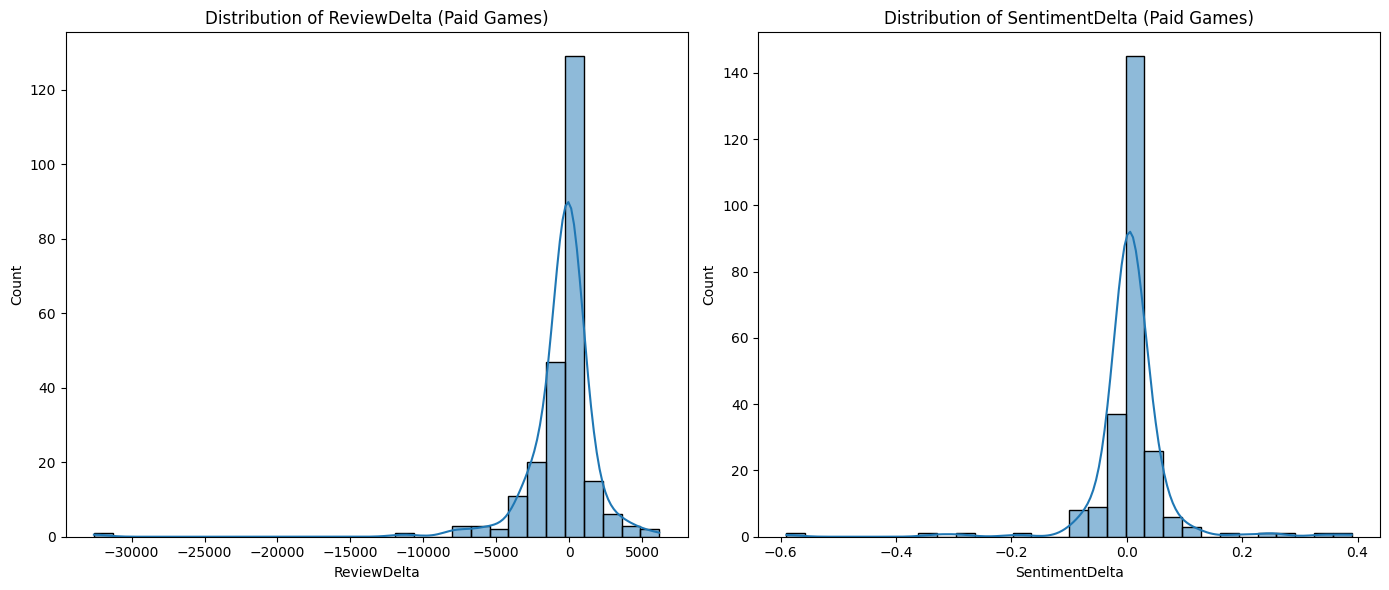

In [75]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.histplot(df_paid_pd["ReviewDelta"].dropna(), bins=30, kde=True)
plt.title("Distribution of ReviewDelta (Paid Games)")

plt.subplot(1,2,2)
sns.histplot(df_paid_pd["SentimentDelta"].dropna(), bins=30, kde=True)
plt.title("Distribution of SentimentDelta (Paid Games)")

plt.tight_layout()
plt.show()


**What this chart shows:**

This set of two charts helps us understand how the number of reviews and the sentiment (or feelings) about paid games change over time.

The first chart ("ReviewDelta") shows how much the number of reviews goes up or down from one day to the next.

The second chart ("SentimentDelta") shows how much the positivity (players liking the game) changes from one day to the next.


**What to notice:**

If the bars in the first chart are mostly around zero, it means the number of reviews stays pretty steady day-to-day. Large bars away from zero show big jumps or drops in reviews.

In the second chart, bars near zero mean the overall player feelings aren’t changing much daily. Bigger bars mean stronger shifts in how players feel about the game — more positive or more negative.

In simple words, these charts tell us if player activity and opinions about paid games stay steady or if they suddenly change a lot.

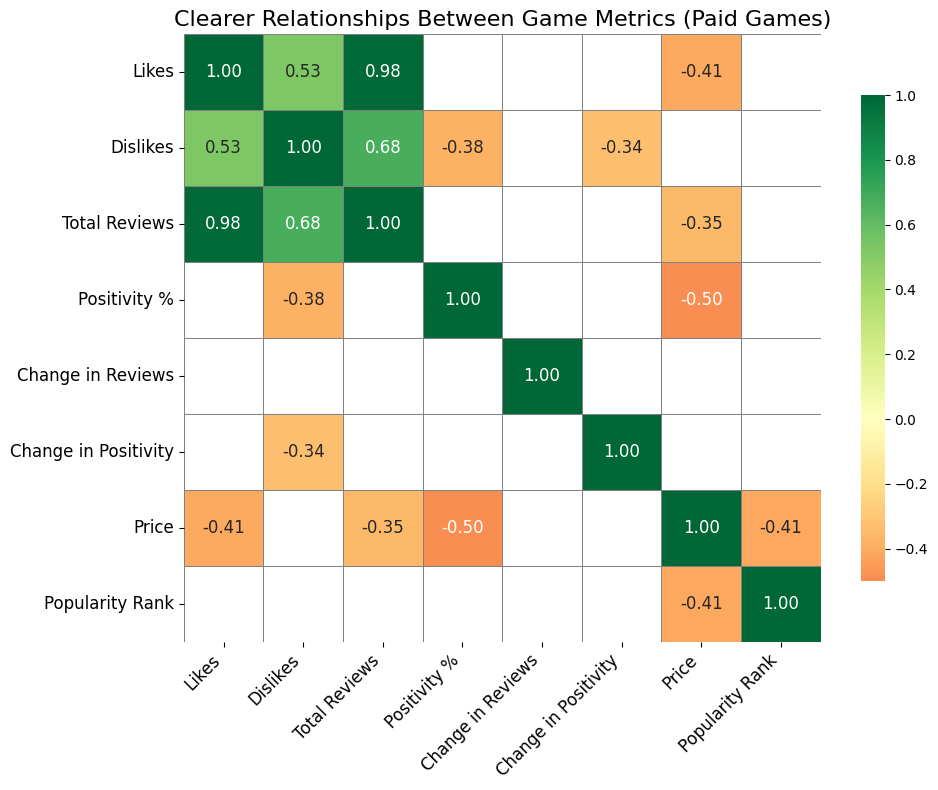

In [98]:
labels = {
    "ThumbsUp": "Likes",
    "ThumbsDown": "Dislikes",
    "TotalReviews": "Total Reviews",
    "PositivityRatio": "Positivity %",
    "ReviewDelta": "Change in Reviews",
    "SentimentDelta": "Change in Positivity",
    "PriceFinal": "Price",
    "Rank": "Popularity Rank"
}

corr_cols = list(labels.keys())
corr = df_paid_pd[corr_cols].corr()

corr_filtered = corr.where(corr.abs() >= 0.3)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_filtered,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    center=0,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={"shrink": 0.8},
    annot_kws={"size":12},
    xticklabels=[labels[col] for col in corr_filtered.columns],
    yticklabels=[labels[col] for col in corr_filtered.index]
)

plt.title("Clearer Relationships Between Game Metrics (Paid Games)", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


**What this chart shows:**


This heatmap helps us see how different aspects of paid games relate to each other. It compares things like the number of likes, dislikes, total reviews, price, and game popularity to find patterns between them.

Each colored square shows how two things move together:

Greenish colors mean they tend to increase or decrease together (positive relationship).

Reddish colors mean when one goes up, the other tends to go down (negative relationship).

White or blank squares mean there’s little or no clear connection.


**What to notice: **

Likes and total reviews are closely linked — games with more reviews usually get more likes.

Likes and dislikes move in opposite directions — more likes usually mean fewer dislikes.

Price and popularity have a moderate connection — cheaper games tend to be more popular.

Changes in the number of reviews and changes in positivity also show a moderate link — big jumps in reviews often come with shifts in how positive players feel.

Some pairs, like price and positivity, don’t show much connection here.


**In simple terms:**


This chart helps us understand what affects game popularity and player feelings. It shows which factors tend to rise or fall together, so game makers can focus on what really influences how much players like a game.

This analysis gives us a better understanding of how player reviews and game pricing relate over time for both paid and free games.

Player sentiment is generally stable but can shift after updates or key changes. Pricing influences player reactions, with affordable games usually receiving more positive feedback. Clustering games by price and sentiment reveals useful patterns to guide pricing and development strategies.

Tracking sentiment changes over time highlights when updates impact player satisfaction, offering valuable insights for developers.

Ultimately, these findings support smarter decisions to improve player experience and increase game success — whether by adjusting pricing, improving updates, or focusing on player feedback.